In [ ]:
# !unzip d2d-data.zip

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import special as sp
from scipy.stats import gaussian_kde
from scipy.io import loadmat
from sklearn.neighbors import KernelDensity
from scipy import special as sp
import warnings
warnings.filterwarnings('ignore')

# Data Load

## D2D data

In [3]:
def D2D_data_linear():   
  """
  Data normalised with respect to their global means
  """
  UE1head_UE2head_LOS_indoor = pd.read_csv('/content/Datasets/D2D_UE1head_UE2head_LOS_Indoor_1khz_mv.txt', delimiter = "\t", header=None)
  UE1head_UE2head_NLOS_indoor = pd.read_csv('/content/Datasets/D2D_UE1head_UE2head_NLOS_indoor_1khz_mv.txt', delimiter = "\t", header=None)
  UE1head_UE2head_NLOS_outdoor = pd.read_csv('/content/Datasets/D2D_UE1head_UE2head_NLOS_outdoor_1khz_mv.txt', delimiter = "\t", header=None)
    
  return UE1head_UE2head_LOS_indoor.T[500:10000].reset_index(drop=True), UE1head_UE2head_NLOS_indoor.T[500:10000].reset_index(drop=True), UE1head_UE2head_NLOS_outdoor.T[500:10000].reset_index(drop=True)

def D2D_SSF_data_linear():   
  """
  Data normalised with respect to their local means (ssf)
  """
  UE1head_UE2pocket_LOS = pd.read_csv('/content/Datasets/d2d_ssf_UE1head_UE2pocket_LOS_mv.txt', delimiter = "\t", header=None, )
  UE1head_UE2pocket_NLOS = pd.read_csv('/content/Datasets/d2d_ssf_UE1head_UE2pocket_NLOS_mv.txt', delimiter = "\t", header=None)
  UE1text_UE2head_LOS = pd.read_csv('/content/Datasets/d2d_ssf_UE1texting_UE2head_LOS_mv.txt', delimiter = "\t", header=None)

  return UE1head_UE2pocket_LOS.T, UE1head_UE2pocket_NLOS.T, UE1text_UE2head_LOS.T


##########################
#### LOAD GLOBAL MEAN ####
##########################
# SSF_pathAB_dB = pd.DataFrame()
UE1head_UE2head_LOS_indoor, \
UE1head_UE2head_NLOS_indoor, \
UE1head_UE2head_NLOS_outdoor = D2D_data_linear()

##########################
####  LOAD LOCAL MEAN ####
##########################
# SSF_pathAB_linear = pd.DataFrame()
UE1head_UE2pocket_LOS, \
UE1head_UE2pocket_NLOS, \
UE1text_UE2head_LOS = D2D_SSF_data_linear()


##########################
#### PRINT STATISTICS ####
##########################
print('Normalised wrt Global Mean')
print('UE1: Head | UE2: Head (LOS - Indoor) Statistics:')
display(UE1head_UE2head_LOS_indoor.describe())
print('UE1: Head | UE2: Head (NLOS - Indoor) Statistics:')
display(UE1head_UE2head_NLOS_indoor.describe())
print('UE1: Head | UE2: Head (NLOS - Outdoor) Statistics:')
display(UE1head_UE2head_NLOS_outdoor.describe())

print('Normalised wrt Local Mean')
print('UE1: Head | UE2: Pocket (LOS) Statistics:')
display(UE1head_UE2pocket_LOS.describe())
print('UE1: Head | UE2: Pocket (NLOS) Statistics:')
display(UE1head_UE2pocket_NLOS.describe())
print('UE1: Texting | UE2: Head (LOS) Statistics:')
display(UE1text_UE2head_LOS.describe())


Normalised wrt Global Mean
UE1: Head | UE2: Head (LOS - Indoor) Statistics:


,0
count,9500.000000
mean,0.921931
std,0.601470
min,0.017674
25%,0.508960
50%,0.773810
75%,1.185725
max,4.710200


UE1: Head | UE2: Head (NLOS - Indoor) Statistics:


,0
count,9500.000000
mean,0.995891
std,0.648062
min,0.012973
25%,0.498070
50%,0.875770
75%,1.381550
max,4.511200


UE1: Head | UE2: Head (NLOS - Outdoor) Statistics:


,0
count,9500.000000
mean,1.063997
std,0.682374
min,0.086185
25%,0.612620
50%,0.915005
75%,1.352000
max,4.497600


Normalised wrt Local Mean
UE1: Head | UE2: Pocket (LOS) Statistics:


,0
count,352.000000
mean,0.984655
std,0.325573
min,0.179790
25%,0.753408
50%,0.987740
75%,1.197825
max,2.244300


UE1: Head | UE2: Pocket (NLOS) Statistics:


,0
count,359.000000
mean,0.963644
std,0.263986
min,0.166430
25%,0.789900
50%,0.954080
75%,1.145800
max,1.933800


UE1: Texting | UE2: Head (LOS) Statistics:


,0
count,329.000000
mean,0.989625
std,0.269059
min,0.182660
25%,0.825610
50%,0.981770
75%,1.162800
max,1.812700


# Auxiliary Methods

In [20]:
def tic():
    #Homemade version of matlab tic and toc functions
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print("Toc: start time not set") 

def shadowedKappaMuPDF(r, kappa, mu, omega, md):
  '''
  shadowed kappa-mu pdf (type 1).
  '''
  A = 2 * r**((2*mu) -1) / omega**(mu)
  B = (mu**mu * md**md * (1+kappa)**mu) / (sp.gamma(mu) * ((mu*kappa)+md)**md)
  C = np.exp((- mu * (1+kappa) * r**2) / omega)
  D = (mu**2) * kappa * (1+kappa) * (r**2)
  E = ((mu*kappa)+md) * omega
  F = sp.hyp1f1(md, mu, D / E)

  pdf = A * B * C * F
  return pdf

def KappaMuPDF(r, kappa, mu, omega):
  '''
  kappa-mu pdf.
  '''
  A = (2*mu * ((1 + kappa)**((mu+1)/2))) \
          /(np.sqrt(omega) * (kappa**((mu-1)/2)) * np.exp(mu * kappa))
  B = (r / np.sqrt(omega))**(mu)
  C = np.exp(-mu*(1+kappa) * (r/np.sqrt(omega))**2)
  D = sp.iv(mu-1, 2*mu * np.sqrt(kappa * (1+kappa)) * (r/np.sqrt(omega)))

  pdf = A * B * C * D
  return pdf

def AlphaMuPDF(r, alpha, mu, r_hat):
  '''
  alpha-mu pdf.
  '''
  A = (alpha * (mu**mu) * (r**((alpha * mu)-1))) / (sp.gamma(mu) * (r_hat**(alpha * mu)))
  B = np.exp( - mu * ((r**alpha) / (r_hat**alpha)))

  pdf = A * B 
  return pdf

def kldiv(pVec1, pVec2):
  '''
  Kullback-Leibler divergence.
  '''
  KL = np.sum(pVec1*(np.log2(pVec1)-np.log2(pVec2)))
  return KL

def RAD(kldiv1, kldiv2):
  '''
  Resistor-Average Distance.
  '''
  RAD = 1/(1/kldiv1+1/kldiv2)
  return RAD

def getDensityEstimationSamples(linear_data, nExtractedSamples, case):
  '''
  Extracted KDE uniformly spaced samples from the data.
  '''
  Xdata = np.linspace(linear_data.min(), linear_data.max(), nExtractedSamples).reshape(-1, 1)
  kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(linear_data.values.reshape(-1, 1))
  
  logkde = kde.score_samples(Xdata)
  Ydata = np.exp(logkde).reshape(-1,1)
  plt.figure(figsize=(10,7))
  plt.scatter(20*np.log10(Xdata), Ydata, c='magenta')
  plt.title(f'{case}')
  plt.ylabel('Density')
  plt.xlabel('Small Scale Fading (dB)')
  plt.grid()
  plt.show()
  return Xdata, Ydata

def printSummary(case, fitnessType):
  print('='*30+'\n'+'Genetic Algorithm Fitting\nFitness Type: {}\nCase: {}\n'.format(fitnessType, case))

def computeAIC(data, n, K, nls_ku, nls_au, ga_ku_mse, ga_ku_rad, ga_au_mse, ga_au_rad, nls_sku, ga_sku_mse, ga_sku_rad):
  # AIC NLS - KAPPA MU
  sum = np.sum(np.log(KappaMuPDF(data, nls_ku[0], nls_ku[1], nls_ku[2]).astype(float)))
  AIC_nls_kappa_mu = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)
  
  # AIC NLS - ALPHA MU
  sum = np.sum(np.log(AlphaMuPDF(data, nls_au[0], nls_au[1], nls_au[2]).astype(float)))
  AIC_nls_alpha_mu = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

  # AIC GENETIC ALGORITHM KAPPA MU - FITNESS: MSE
  sum = np.sum(np.log(KappaMuPDF(data, ga_ku_mse[0], ga_ku_mse[1], ga_ku_mse[2])))
  AIC_ga_kappa_mu = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)
  
  # AIC GENETIC ALGORITHM KAPPA MU - FITNESS: RAD
  sum = np.sum(np.log(KappaMuPDF(data, ga_ku_rad[0], ga_ku_rad[1], ga_ku_rad[2])))
  AIC_ga_kappa_mu_rad = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

  # AIC GENETIC ALGORITHM ALPHA MU - FITNESS: MSE
  sum = np.sum(np.log(AlphaMuPDF(data, ga_au_mse[0], ga_au_mse[1], ga_au_mse[2])))
  AIC_ga_alpha_mu = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

  # AIC GENETIC ALGORITHM ALPHA MU - FITNESS: RAD
  sum = np.sum(np.log(AlphaMuPDF(data, ga_au_rad[0], ga_au_rad[1], ga_au_rad[2])))
  AIC_ga_alpha_mu_rad = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

  K = K+1

  # AIC NLS - SHADOWED KAPPA MU
  sum = np.sum(np.log(shadowedKappaMuPDF(data, nls_sku[0], nls_sku[1], nls_sku[2], nls_sku[3]).astype(float)))
  AIC_nls_shadowed_kappa_mu = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

  # AIC GENETIC ALGORITHM SHADOWED KAPPA MU - FITNESS: MSE
  sum = np.sum(np.log(shadowedKappaMuPDF(data, ga_sku_mse[0], ga_sku_mse[1], ga_sku_mse[2], ga_sku_mse[3])))
  AIC_ga_shadowed_kappa_mu = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

  # AIC GENETIC ALGORITHM SHADOWED KAPPA MU - FITNESS: RAD
  sum = np.sum(np.log(shadowedKappaMuPDF(data, ga_sku_rad[0], ga_sku_rad[1], ga_sku_rad[2], ga_sku_rad[3])))
  AIC_ga_shadowed_kappa_mu_rad = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

  rads = {'Methods':['NLS - KappaMu', 'NLS - AlphaMu', \
                      'GA - KappaMu (Fitness = MSE)', 'GA - KappaMu (Fitness = RAD)',\
                      'GA - AlphaMu (Fitness = MSE)', 'GA - AlphaMu (Fitness = RAD)',\
                     'NLS - Shad. KappaMu T1', 'GA - Shad. KappaMu T1 (Fitness = MSE)',\
                     'GA - Shad. KappaMu T1 (Fitness = RAD)'],
          
      'Akaike Information Criteria':[AIC_nls_kappa_mu[0], AIC_nls_alpha_mu[0], 
                                     AIC_ga_kappa_mu[0], AIC_ga_kappa_mu_rad[0],
                                     AIC_ga_alpha_mu[0] , AIC_ga_alpha_mu_rad[0],
                                     AIC_nls_shadowed_kappa_mu[0], AIC_ga_shadowed_kappa_mu[0], AIC_ga_shadowed_kappa_mu_rad[0]]}

  df = pd.DataFrame(rads)
  display(df.sort_values(by='Akaike Information Criteria').reset_index(drop=True))
  return df

def plotResults(Xdata, Ydata, ku_pdf, au_pdf, ga_ku_mse, ga_ku_rad, ga_au_mse, ga_au_rad, sku_pdf, ga_sku_mse, ga_sku_rad, case):
    plt.figure(figsize=((10,7)))
    plt.scatter(20*np.log10(Xdata), Ydata, c='black')
    plt.plot(20*np.log10(Xdata), ku_pdf, label=r'$\kappa$-$\mu$ NLS')
    plt.plot(20*np.log10(Xdata), au_pdf, label=r'$\alpha$-$\mu$ NLS')
    plt.plot(20*np.log10(Xdata), KappaMuPDF(Xdata, ga_ku_mse[0], ga_ku_mse[1], ga_ku_mse[2]), label=r'GA: $\kappa$-$\mu$ (MSE)')
    plt.plot(20*np.log10(Xdata), KappaMuPDF(Xdata, ga_ku_rad[0], ga_ku_rad[1], ga_ku_rad[2]), label=r'GA: $\kappa$-$\mu$ (RAD)')
    plt.plot(20*np.log10(Xdata), AlphaMuPDF(Xdata, ga_au_mse[0], ga_au_mse[1], ga_au_mse[2]), label=r'GA: $\alpha$-$\mu$ (MSE)')
    plt.plot(20*np.log10(Xdata), AlphaMuPDF(Xdata, ga_au_rad[0], ga_au_rad[1], ga_au_rad[2]), label=r'GA: $\alpha$-$\mu$ (RAD)')
    plt.plot(20*np.log10(Xdata), sku_pdf, label=r'Shad. $\kappa$-$\mu$ NLS')
    plt.plot(20*np.log10(Xdata), shadowedKappaMuPDF(Xdata, ga_sku_mse[0], ga_sku_mse[1], ga_sku_mse[2], ga_sku_mse[3]), label='Shad. $\kappa$-$\mu$ GA (MSE)')
    plt.plot(20*np.log10(Xdata), shadowedKappaMuPDF(Xdata, ga_sku_rad[0], ga_sku_rad[1], ga_sku_rad[2], ga_sku_rad[3]), label='Shad. $\kappa$-$\mu$ GA (RAD)')
    
    plt.title(f'{case}')
    plt.legend()
    plt.grid(True)
    plt.xlabel(r'Small Scale Fading (dB)')
    plt.ylabel('Density')
    plt.savefig('(dB) ku-au-sku_case_{}.pdf'.format(case, dpi=150))
    plt.show()
    
    plt.figure(figsize=((10,7)))
    plt.scatter(Xdata, Ydata, c='black')
    plt.plot(Xdata, ku_pdf, label=r'$\kappa$-$\mu$ NLS')
    plt.plot(Xdata, au_pdf, label=r'$\alpha$-$\mu$ NLS')
    plt.plot(Xdata, KappaMuPDF(Xdata, ga_ku_mse[0], ga_ku_mse[1], ga_ku_mse[2]), label=r'GA: $\kappa$-$\mu$ (MSE)')
    plt.plot(Xdata, KappaMuPDF(Xdata, ga_ku_rad[0], ga_ku_rad[1], ga_ku_rad[2]), label=r'GA: $\kappa$-$\mu$ (RAD)')
    plt.plot(Xdata, AlphaMuPDF(Xdata, ga_au_mse[0], ga_au_mse[1], ga_au_mse[2]), label=r'GA: $\alpha$-$\mu$ (MSE)')
    plt.plot(Xdata, AlphaMuPDF(Xdata, ga_au_rad[0], ga_au_rad[1], ga_au_rad[2]), label=r'GA: $\alpha$-$\mu$ (RAD)')
    plt.plot(Xdata, sku_pdf, label=r'Shad. $\kappa$-$\mu$ NLS')
    plt.plot(Xdata, shadowedKappaMuPDF(Xdata, ga_sku_mse[0], ga_sku_mse[1], ga_sku_mse[2], ga_sku_mse[3]), label='Shad. $\kappa$-$\mu$ GA (MSE)')
    plt.plot(Xdata, shadowedKappaMuPDF(Xdata, ga_sku_rad[0], ga_sku_rad[1], ga_sku_rad[2], ga_sku_rad[3]), label='Shad. $\kappa$-$\mu$ GA (RAD)')
    plt.title(f'{case}')
    plt.legend()
    plt.grid(True)
    plt.xlabel(r'Small Scale Fading (linear)')
    plt.ylabel('Density')
    plt.savefig('(linear) ku-au-sku_case_{}.pdf'.format(case, dpi=150))
    plt.show()

In [5]:
def fitness_au(X, Y, fitnessType, alpha, mu, r_hat):
  '''
  Fitness function (MSE/RAD) to determine how good a given solution is.
  (Alpha Mu)
  '''
  if fitnessType == 'MSE':
    y_pred = AlphaMuPDF(X, alpha, mu, r_hat)
    n = len(Y)
    cost = 1/n * np.sum(val**2 for val in (Y-y_pred))
    return 1/cost
  elif fitnessType == 'RAD':
    pVec1 = Y/np.sum(Y)
    pVec2 = AlphaMuPDF(X, alpha, mu, r_hat)/np.sum(AlphaMuPDF(X, alpha, mu, r_hat))
    KLD_1 = kldiv(pVec1, pVec2)
    KLD_2 = kldiv(pVec2, pVec1)
    cost = RAD(KLD_1, KLD_2)
    return 1/cost


def geneticAlgorithm_au(X, Y, threshold, firstFlag=True):
  '''
  Genetic Algorithm incorporating Alpha Mu in the Fitness Function
  It fits alpha, mu, r_hat
  '''
  if firstFlag:
        tic()
  solutions = []
  bestParams = []
  bestCriteria = 0
  bestGen = 0


  # Generate solutions (chromossomes)
  for s in range(nPopulation):
    solutions.append((random.uniform(0.01, 10), # alpha
                        random.uniform(0.01, 5), # mu
                        random.uniform(0.01, 2))) # r_hat

  # Evolutionary Loop
  for i in range(nMaxGen):
    rankedSolutions = []
    for s in solutions:
      # if s[3] > 110: # Forcing Ms parameter to not get too high (avoiding overflow)
      #   s = list(s)
      #   s[3] = 105
      #   s = tuple(s)
      rankedSolutions.append( (fitness_au(X, Y, fitnessType, s[0],s[1],s[2]), s) )
    rankedSolutions.sort()
    rankedSolutions.reverse()
    
    # print(f'=== Generation: {i} === ')
    # print(f'Fitness: {rankedSolutions[0][0]}')
    # print('Best individual:')
    # print(f'Kappa: {rankedSolutions[0][1][0]}')
    # print(f'Mu: {rankedSolutions[0][1][1]}')
    # print(f'Omega: {rankedSolutions[0][1][2]}')
    # print(f'Ms {rankedSolutions[0][1][3]}\n')

    # Keeping track the best params and generation:
    if rankedSolutions[0][0] > bestCriteria:
      bestCriteria = rankedSolutions[0][0]
      bestGen = i
      bestParams = rankedSolutions[0][1]
    
    # Check if it is good enough according to a satisfactory threshold:
    if bestCriteria > threshold:
      print('Satisfactory Threshold reached!')  
      toc()
      print('\nBest Fitness: {}\nBest Gen: {}'.format(bestCriteria, bestGen))
      print('Kappa: {}\nMu: {}\nR_hat: {}'.format(bestParams[0],bestParams[1],bestParams[2]))
      return bestParams[0],bestParams[1],bestParams[2]

    # Combine the best solutions and make a new solution of those combined solutions
    bestSolutions = rankedSolutions[:100]
    elements_alpha = []
    elements_mu = []
    elements_r_hat = [] 

    for s in bestSolutions:
      elements_alpha.append(s[1][0])
      elements_mu.append(s[1][1])
      elements_r_hat.append(s[1][2])


    newGen = []
    for _ in range(nPopulation):
      e1 = random.choice(elements_alpha) * random.uniform(0.975,1.025) # Mutation of 5%
      e2 = random.choice(elements_mu) * random.uniform(0.975,1.025) # Mutation of 5%
      e3 = random.choice(elements_r_hat) * random.uniform(0.975,1.025) # Mutation of 5%
      
      newGen.append((e1,e2,e3))

    solutions = newGen
    
    if i == nMaxGen-1:
      print('Max number of generations reached! (Possible bad initialization)\nRestarting...\n')
      b0, b1, b2 = geneticAlgorithm_au(X, Y, threshold, False)
    
      return b0, b1, b2

In [6]:
def fitness_ku(X, Y, fitnessType, kappa, mu, omega):
  '''
  Fitness function (MSE/RAD) to determine how good a given solution is.
  (Kappa Mu)
  '''
  if fitnessType == 'MSE':
    y_pred = KappaMuPDF(X, kappa, mu, omega).astype(float)
    n = len(Y)
    sum = []
    for val in (Y-y_pred):
      sum.append(val**2)
    sum = np.sum(sum)
    cost = 1/n * sum
    return 1/cost
  elif fitnessType == 'RAD':
    pVec1 = Y/np.sum(Y)
    pVec2 = KappaMuPDF(X, kappa, mu, omega).astype(float)/np.sum(KappaMuPDF(X, kappa, mu, omega).astype(float))
    KLD_1 = kldiv(pVec1, pVec2)
    KLD_2 = kldiv(pVec2, pVec1)
    cost = RAD(KLD_1, KLD_2)
    return 1/cost


def geneticAlgorithm_ku(X, Y, threshold, firstFlag=True):
  '''
  Genetic Algorithm incorporating Kappa Mu in the Fitness Function
  It fits kappa, mu, omega
  '''
  if firstFlag:
        tic()
  solutions = []
  bestParams = []
  bestCriteria = 0
  bestGen = 0


  # Generate solutions (chromossomes)
  for s in range(nPopulation):
    solutions.append((random.uniform(0.1, 70), # kappa
                        random.uniform(0.01, 1.5), # mu
                        random.uniform(0.01, 2)))  # omega = r_hat^2
              
  # Evolutionary Loop
  for i in range(nMaxGen):
    rankedSolutions = []	
    for s in solutions:
      # if s[0] > 90: # Forcing Ms parameter to not get too high (avoiding overflow)
      #   s = list(s)
      #   s[0] = 90
      #   s = tuple(s)
      rankedSolutions.append( (fitness_ku(X, Y, fitnessType, s[0],s[1],s[2]), s) )
    rankedSolutions.sort()
    rankedSolutions.reverse()
    
    # print(f'=== Generation: {i} === ')
    # print(f'Fitness: {rankedSolutions[0][0]}')
    # print('Best individual:')
    # print(f'Kappa: {rankedSolutions[0][1][0]}')
    # print(f'Mu: {rankedSolutions[0][1][1]}')
    # print(f'Omega: {rankedSolutions[0][1][2]}\n')

    # Keeping track the best params and generation:
    if rankedSolutions[0][0] > bestCriteria:
      bestCriteria = rankedSolutions[0][0]
      bestGen = i
      bestParams = rankedSolutions[0][1]

    # Check if it is good enough according to a satisfactory threshold:
    if bestCriteria > threshold:
      print('Satisfactory Threshold reached!')  
      toc()
      print('\nBest Fitness: {}\nBest Gen: {}'.format(bestCriteria, bestGen))
      print('Kappa: {}\nMu: {}\nOmega: {}'.format(bestParams[0],bestParams[1],bestParams[2]))
      return bestParams[0],bestParams[1],bestParams[2]
    
    # Combine the best solutions and make a new solution of those combined solutions
    bestSolutions = rankedSolutions[:100]
    elements_kappa = []
    elements_mu = []
    elements_omega = [] 

    for s in bestSolutions:
      elements_kappa.append(s[1][0])
      elements_mu.append(s[1][1])
      elements_omega.append(s[1][2])


    newGen = []
    for _ in range(nPopulation):
      e1 = random.choice(elements_kappa) * random.uniform(0.975,1.025) # Mutation of 5%
      e2 = random.choice(elements_mu) * random.uniform(0.975,1.025) # Mutation of 5%
      e3 = random.choice(elements_omega) * random.uniform(0.975,1.025) # Mutation of 5%

      
      newGen.append((e1,e2,e3))

    solutions = newGen
    
    if i == nMaxGen-1:
      print('Max number of generations reached! (Possible bad initialization)\nRestarting...\n')
      b0, b1, b2 = geneticAlgorithm_ku(X, Y, threshold, False)
    
      return b0, b1, b2

In [7]:
def fitness_sku(X, Y, fitnessType, kappa, mu, omega, md):
  '''
  Fitness function (MSE/RAD) to determine how good a given solution is.
  (Shadowed Kappa Mu Type 1)
  '''
  if fitnessType == 'MSE':
    y_pred = shadowedKappaMuPDF(X, kappa, mu, omega, md)
    n = len(Y)
    sum = []
    for val in (Y-y_pred):
      sum.append(val**2)
    sum = np.sum(sum)
    cost = 1/n * sum
    return 1/cost
  elif fitnessType == 'RAD':
    pVec1 = Y/np.sum(Y)
    pVec2 = shadowedKappaMuPDF(X, kappa, mu, omega, md)/np.sum(shadowedKappaMuPDF(X, kappa, mu, omega, md))
    KLD_1 = kldiv(pVec1, pVec2)
    KLD_2 = kldiv(pVec2, pVec1)
    cost = RAD(KLD_1, KLD_2)
    return 1/cost


def geneticAlgorithm_sku(X, Y, threshold, firstFlag=True):
  '''
  Genetic Algorithm incorporating Shadowed Kappa Mu Type 1 in the Fitness Function
  It fits kappa, mu, omega, md
  '''
  if firstFlag:
        tic()
  solutions = []
  bestParams = []
  bestCriteria = 0
  bestGen = 0


  # Generate solutions (chromossomes)
  for s in range(nPopulation):
    solutions.append((random.uniform(0.01, 11), # kappa
                        random.uniform(0.01, 3.0), # mu
                        random.uniform(0.01, 3.0), # r_hat^2
                        random.uniform(0.01, 20.0))) # md

  # Evolutionary Loop
  for i in range(nMaxGen):
    rankedSolutions = []
    for s in solutions:
      rankedSolutions.append( (fitness_sku(X, Y, fitnessType, s[0],s[1],s[2],s[3]), s) )
    rankedSolutions.sort()
    rankedSolutions.reverse()
    
    # print(f'=== Generation: {i} === ')
    # print(f'Fitness: {rankedSolutions[0][0]}')
    # print('Best individual:')
    # print(f'Kappa: {rankedSolutions[0][1][0]}')
    # print(f'Mu: {rankedSolutions[0][1][1]}')
    # print(f'Omega: {rankedSolutions[0][1][2]}')
    # print(f'Md: {rankedSolutions[0][1][3]}\n')

    # Keeping track the best params and generation:
    if rankedSolutions[0][0] > bestCriteria:
      bestCriteria = rankedSolutions[0][0]
      bestGen = i
      bestParams = rankedSolutions[0][1]

    # Check if it is good enough according to a satisfactory threshold:
    if bestCriteria > threshold:
      print('Satisfactory Threshold reached!')  
      toc()
      print('\nBest Fitness: {}\nBest Gen: {}'.format(bestCriteria, bestGen))
      print('Kappa: {}\nMu: {}\nOmega: {}\nMd: {}'.format(bestParams[0],bestParams[1],bestParams[2],bestParams[3]))
      return bestParams[0],bestParams[1],bestParams[2],bestParams[3]
    
    # Combine the best solutions and make a new solution of those combined solutions
    bestSolutions = rankedSolutions[:100]
    elements_kappa = []
    elements_mu = []
    elements_omega = [] 
    elements_md = [] 
    for s in bestSolutions:
      elements_kappa.append(s[1][0])
      elements_mu.append(s[1][1])
      elements_omega.append(s[1][2])
      elements_md.append(s[1][3])

    newGen = []
    for _ in range(nPopulation):
      e1 = random.choice(elements_kappa) * random.uniform(0.975,1.025) # Mutation of 5%
      e2 = random.choice(elements_mu) * random.uniform(0.975,1.025) # Mutation of 5%
      e3 = random.choice(elements_omega) * random.uniform(0.975,1.025) # Mutation of 5%
      e4 = random.choice(elements_md) * random.uniform(0.975,1.025) # Mutation of 5%
      
      newGen.append((e1,e2,e3,e4))

    solutions = newGen
    
    if i == nMaxGen-1:
      print('Max number of generations reached! (Possible bad initialization)\nRestarting...\n')
      b0, b1, b2, b3 = geneticAlgorithm_sku(X, Y, threshold, False)
        
      return b0, b1, b2, b3

# Small Scale Fading Fitting (PARAMETERS)

In [8]:
### PARAMETERS
nMaxGen = 200
nPopulation = 1000
nExtractedSamples = 81

## $\alpha$-$\mu$ and $\kappa$-$\mu$



### D2D UE1 head - UE2 pocket LOS (indoor) [Case 1]

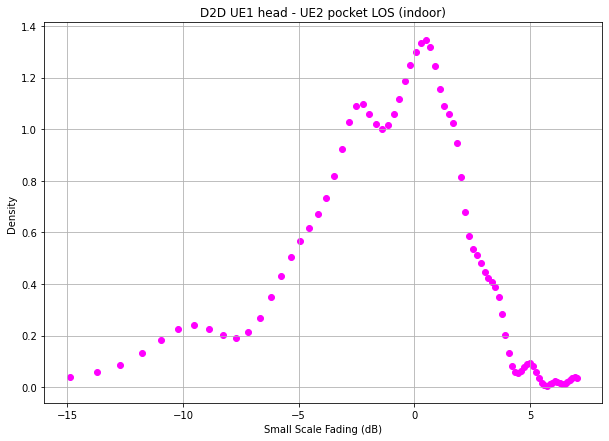

In [14]:
case = 'D2D UE1 head - UE2 pocket LOS (indoor)'
estParameters_au_ku_case1 = pd.DataFrame()
estParameters_sku_case1 = pd.DataFrame()
Xdata, Ydata = getDensityEstimationSamples(UE1head_UE2pocket_LOS.dropna(), nExtractedSamples, case)

In [24]:
print('='*30+' KAPPA-MU '+'='*30)
fitnessType = 'MSE'
printSummary(case, fitnessType)
ku_kappa_mse, ku_mu_mse, ku_omega_mse = geneticAlgorithm_ku(Xdata, Ydata, 230)

fitnessType = 'RAD'
printSummary(case, fitnessType)
ku_kappa_rad, ku_mu_rad, ku_omega_rad = geneticAlgorithm_ku(Xdata, Ydata, 77)

print('='*30+' ALPHA-MU '+'='*30)
fitnessType = 'MSE'
printSummary(case, fitnessType)
au_kappa_mse, au_mu_mse, au_r_hat_mse = geneticAlgorithm_au(Xdata, Ydata, 219)

fitnessType = 'RAD'
printSummary(case, fitnessType)
au_kappa_rad, au_mu_rad, au_r_hat_rad = geneticAlgorithm_au(Xdata, Ydata, 56)

print('='*30+' SHADOWED KAPPA-MU T1 '+'='*30)
fitnessType = 'MSE'
printSummary(case, fitnessType)
sku_kappa_mse, sku_mu_mse, sku_omega_mse, sku_md_mse = geneticAlgorithm_sku(Xdata, Ydata, 230)

fitnessType = 'RAD'
printSummary(case, fitnessType)
sku_kappa_rad, sku_mu_rad, sku_omega_rad, sku_md_rad = geneticAlgorithm_sku(Xdata, Ydata, 78)

============================== SHADOWED KAPPA-MU T1 ==============================
Genetic Algorithm Fitting
Fitness Type: MSE
Case: D2D UE1 head - UE2 pocket LOS (indoor)

Max number of generations reached! (Possible bad initialization)
Restarting...

Max number of generations reached! (Possible bad initialization)
Restarting...

Max number of generations reached! (Possible bad initialization)
Restarting...

Satisfactory Threshold reached!
Elapsed time is 165.76424837112427 seconds.

Best Fitness: 230.01002904580548
Best Gen: 145
Kappa: 6.0220005618605805
Mu: 0.7773667485813388
Omega: 1.0572710817596993
Md: 31.319713219717663
Genetic Algorithm Fitting
Fitness Type: RAD
Case: D2D UE1 head - UE2 pocket LOS (indoor)

Satisfactory Threshold reached!
Elapsed time is 0.6484019756317139 seconds.

Best Fitness: 78.56850388782246
Best Gen: 2
Kappa: 8.60825451496777
Mu: 0.7745049038524298
Omega: 1.0442969278122942
Md: 6.415093578440123


#### Estimated Parameters

In [25]:
nls_ku_case1 = [70, 0.076636, 1.048] # KappaMu NLS
nls_au_case1 = [3.6888, 0.93352, 1.0856] # AlphaMu NLS
nls_sku_case1 = [9.6901, 0.51619, 1.0613, 20]

estParameters_au_ku_case1['NLS - KappaMu'] = nls_ku_case1
estParameters_au_ku_case1['NLS - AlphaMu'] = nls_au_case1
estParameters_au_ku_case1['GA: KappaMu - MSE'] = ku_kappa_mse, ku_mu_mse, ku_omega_mse
estParameters_au_ku_case1['GA: KappaMu - RAD'] = ku_kappa_rad, ku_mu_rad, ku_omega_rad
estParameters_au_ku_case1['GA: AlphaMu - MSE'] = au_kappa_mse, au_mu_mse, au_r_hat_mse
estParameters_au_ku_case1['GA: AlphaMu - RAD'] = au_kappa_rad, au_mu_rad, au_r_hat_rad
estParameters_sku_case1['NLS - Shad. KappaMu T1'] = nls_sku_case1
estParameters_sku_case1['GA: Shad. KappaMu T1 - MSE'] = sku_kappa_mse, sku_mu_mse, sku_omega_mse, sku_md_mse
estParameters_sku_case1['GA: Shad. KappaMu T1 - RAD'] = sku_kappa_rad, sku_mu_rad, sku_omega_rad, sku_md_rad

index = pd.Index(['kappa', 'mu', 'omega/r_hat'])
estParameters_au_ku_case1 = estParameters_au_ku_case1.set_index(index)
display(estParameters_au_ku_case1)

index = pd.Index(['kappa', 'mu', 'omega', 'md'])
estParameters_sku_case1 = estParameters_sku_case1.set_index(index)
display(estParameters_sku_case1)

,NLS - KappaMu,NLS - AlphaMu,GA: KappaMu - MSE,GA: KappaMu - RAD,GA: AlphaMu - MSE,GA: AlphaMu - RAD
kappa,70.000000,3.68880,46.517202,10.928808,3.433902,2.152145
mu,0.076636,0.93352,0.114876,0.432652,1.069256,1.978956
omega/r_hat,1.048000,1.08560,1.047894,1.053709,1.085159,1.033067


,NLS - Shad. KappaMu T1,GA: Shad. KappaMu T1 - MSE,GA: Shad. KappaMu T1 - RAD
kappa,9.69010,6.022001,8.608255
mu,0.51619,0.777367,0.774505
omega,1.06130,1.057271,1.044297
md,20.00000,31.319713,6.415094


#### Plots

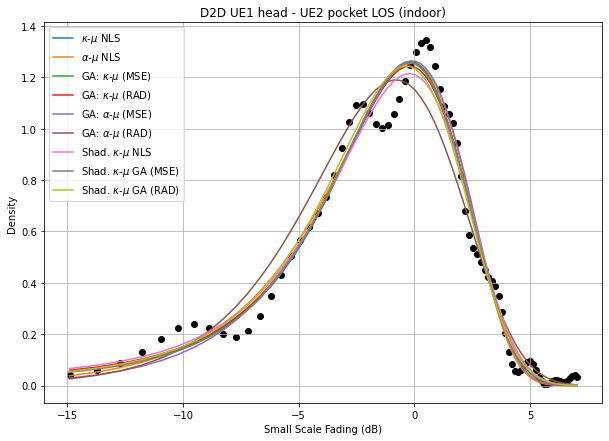

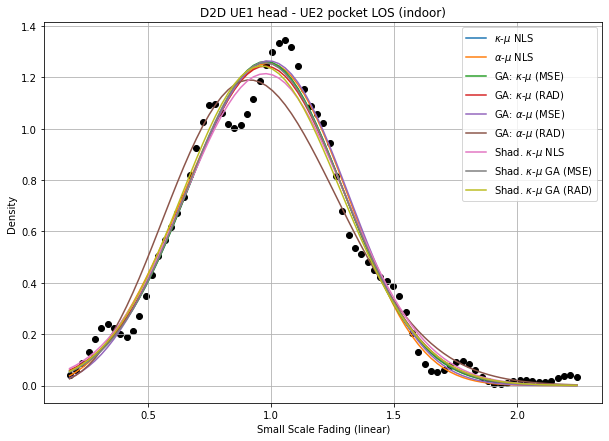

In [26]:
ku_case1_pdf = KappaMuPDF(Xdata, nls_ku_case1[0], nls_ku_case1[1], nls_ku_case1[2]).astype(float)
au_case1_pdf = AlphaMuPDF(Xdata, nls_au_case1[0], nls_au_case1[1], nls_au_case1[2]).astype(float)
sku_case1_pdf = shadowedKappaMuPDF(Xdata, nls_sku_case1[0], nls_sku_case1[1], nls_sku_case1[2], nls_sku_case1[3]).astype(float)


plotResults(Xdata,\
     Ydata,\
     ku_case1_pdf,\
     au_case1_pdf,\
     estParameters_au_ku_case1['GA: KappaMu - MSE'],\
     estParameters_au_ku_case1['GA: KappaMu - RAD'],\
     estParameters_au_ku_case1['GA: AlphaMu - MSE'],\
     estParameters_au_ku_case1['GA: AlphaMu - RAD'],\
     sku_case1_pdf,\
     estParameters_sku_case1['GA: Shad. KappaMu T1 - MSE'],\
     estParameters_sku_case1['GA: Shad. KappaMu T1 - RAD'],\
     case)

#### AIC Values

In [27]:
## AIC Analysis
data = UE1head_UE2pocket_LOS.dropna()
n = len(data)
K = 3

print('Case: {}'.format(case))

AIC_case1 = computeAIC(data, n, K,\
                        nls_ku_case1,\
                        nls_au_case1,\
                        estParameters_au_ku_case1['GA: KappaMu - MSE'],\
                        estParameters_au_ku_case1['GA: KappaMu - RAD'],\
                        estParameters_au_ku_case1['GA: AlphaMu - MSE'],\
                        estParameters_au_ku_case1['GA: AlphaMu - RAD'],\
                        nls_sku_case1,\
                        estParameters_sku_case1['GA: Shad. KappaMu T1 - MSE'],\
                        estParameters_sku_case1['GA: Shad. KappaMu T1 - RAD'])

Case: D2D UE1 head - UE2 pocket LOS (indoor)
4


,Methods,Akaike Information Criteria
0,GA - AlphaMu (Fitness = RAD),211.552733
1,GA - Shad. KappaMu T1 (Fitness = RAD),214.230449
2,GA - KappaMu (Fitness = RAD),214.624586
3,GA - Shad. KappaMu T1 (Fitness = MSE),215.233163
4,NLS - Shad. KappaMu T1,215.918292
5,GA - KappaMu (Fitness = MSE),216.671046
6,NLS - KappaMu,216.771291
7,GA - AlphaMu (Fitness = MSE),221.995862
8,NLS - AlphaMu,226.392038


### D2D UE1 head - UE2 pocket NLOS (indoor) [Case 2]

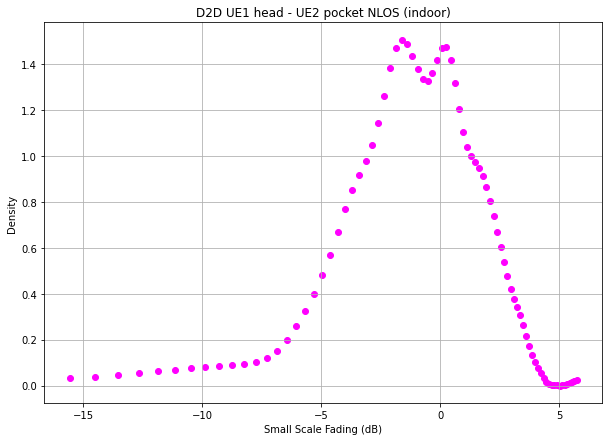

In [28]:
case = 'D2D UE1 head - UE2 pocket NLOS (indoor)'
estParameters_au_ku_case2 = pd.DataFrame()
estParameters_sku_case2 = pd.DataFrame()
Xdata, Ydata = getDensityEstimationSamples(UE1head_UE2pocket_NLOS.dropna(), nExtractedSamples, case)

In [29]:
print('='*30+' KAPPA-MU '+'='*30)
fitnessType = 'MSE'
printSummary(case, fitnessType)
ku_kappa_mse, ku_mu_mse, ku_omega_mse = geneticAlgorithm_ku(Xdata, Ydata, 250) 

fitnessType = 'RAD'
printSummary(case, fitnessType)
ku_kappa_rad, ku_mu_rad, ku_omega_rad = geneticAlgorithm_ku(Xdata, Ydata, 113) 

print('='*30+' ALPHA-MU '+'='*30)
fitnessType = 'MSE'
printSummary(case, fitnessType)
au_kappa_mse, au_mu_mse, au_r_hat_mse = geneticAlgorithm_au(Xdata, Ydata, 310)

fitnessType = 'RAD'
printSummary(case, fitnessType)
au_kappa_rad, au_mu_rad, au_r_hat_rad = geneticAlgorithm_au(Xdata, Ydata, 100)

print('='*30+' SHADOWED KAPPA-MU T1 '+'='*30)
fitnessType = 'MSE'
printSummary(case, fitnessType)
sku_kappa_mse, sku_mu_mse, sku_omega_mse, sku_md_mse = geneticAlgorithm_sku(Xdata, Ydata, 276)

fitnessType = 'RAD'
printSummary(case, fitnessType)
sku_kappa_rad, sku_mu_rad, sku_omega_rad, sku_md_rad = geneticAlgorithm_sku(Xdata, Ydata, 92)

============================== KAPPA-MU ==============================
Genetic Algorithm Fitting
Fitness Type: MSE
Case: D2D UE1 head - UE2 pocket NLOS (indoor)

Max number of generations reached! (Possible bad initialization)
Restarting...

Max number of generations reached! (Possible bad initialization)
Restarting...

Satisfactory Threshold reached!
Elapsed time is 156.13250255584717 seconds.

Best Fitness: 250.66585294011395
Best Gen: 119
Kappa: 2.0076961613818107
Mu: 1.9397882465493381
Omega: 0.9912389232219943
Genetic Algorithm Fitting
Fitness Type: RAD
Case: D2D UE1 head - UE2 pocket NLOS (indoor)

Satisfactory Threshold reached!
Elapsed time is 2.223737955093384 seconds.

Best Fitness: 113.80091700016878
Best Gen: 7
Kappa: 10.27584334054337
Mu: 0.6298032134346809
Omega: 0.9881829863192878
============================== ALPHA-MU ==============================
Genetic Algorithm Fitting
Fitness Type: MSE
Case: D2D UE1 head - UE2 pocket NLOS (indoor)

Satisfactory Threshold reached!

#### Estimated Parameters

In [30]:
nls_ku_case2 = [3.0556, 1.5, 0.98751] # KappaMu NLS
nls_au_case2 = [1.7212, 4.4732, 1.0033] # AlphaMu NLS
nls_sku_case2 = [0.30643, 2.9993, 1.028, 20] # Shad. KappaMu T1 NLS

estParameters_au_ku_case2['MLE - KappaMu'] = nls_ku_case2
estParameters_au_ku_case2['MLE - AlphaMu'] = nls_au_case2
estParameters_au_ku_case2['GA: KappaMu - MSE'] = ku_kappa_mse, ku_mu_mse, ku_omega_mse
estParameters_au_ku_case2['GA: KappaMu - RAD'] = ku_kappa_rad, ku_mu_rad, ku_omega_rad
estParameters_au_ku_case2['GA: AlphaMu - MSE'] = au_kappa_mse, au_mu_mse, au_r_hat_mse
estParameters_au_ku_case2['GA: AlphaMu - RAD'] = au_kappa_rad, au_mu_rad, au_r_hat_rad
estParameters_sku_case2['NLS - Shad. KappaMu T1'] = nls_sku_case2
estParameters_sku_case2['GA: Shad. KappaMu T1 - MSE'] = sku_kappa_mse, sku_mu_mse, sku_omega_mse, sku_md_mse
estParameters_sku_case2['GA: Shad. KappaMu T1 - RAD'] = sku_kappa_rad, sku_mu_rad, sku_omega_rad, sku_md_rad

index = pd.Index(['kappa', 'mu', 'omega/r_hat'])
estParameters_au_ku_case2 = estParameters_au_ku_case2.set_index(index)
display(estParameters_au_ku_case2)

index = pd.Index(['kappa', 'mu', 'omega', 'md'])
estParameters_sku_case2 = estParameters_sku_case2.set_index(index)
display(estParameters_sku_case2)

,MLE - KappaMu,MLE - AlphaMu,GA: KappaMu - MSE,GA: KappaMu - RAD,GA: AlphaMu - MSE,GA: AlphaMu - RAD
kappa,3.05560,1.7212,2.007696,10.275843,1.928602,3.188017
mu,1.50000,4.4732,1.939788,0.629803,3.626931,1.530381
omega/r_hat,0.98751,1.0033,0.991239,0.988183,0.998436,1.039275


,NLS - Shad. KappaMu T1,GA: Shad. KappaMu T1 - MSE,GA: Shad. KappaMu T1 - RAD
kappa,0.30643,10.052239,1.899760
mu,2.99930,2.980275,2.404614
omega,1.02800,0.992735,1.013512
md,20.00000,3.654466,16.020700


#### Plots

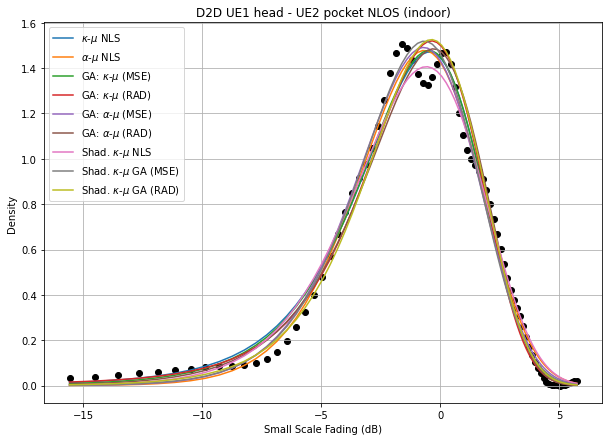

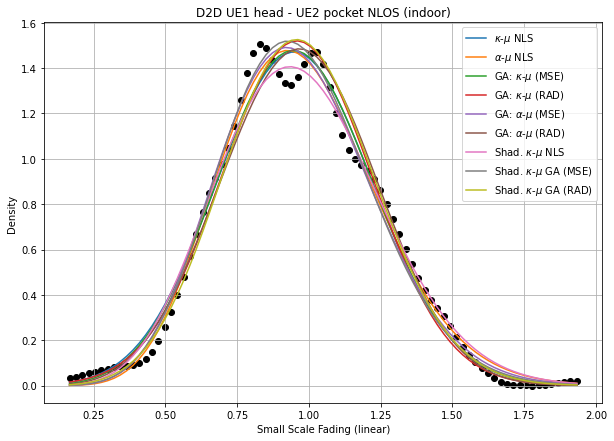

In [31]:
ku_case2_pdf = KappaMuPDF(Xdata, nls_ku_case2[0], nls_ku_case2[1], nls_ku_case2[2]).astype(float)
au_case2_pdf = AlphaMuPDF(Xdata, nls_au_case2[0], nls_au_case2[1], nls_au_case2[2]).astype(float)
sku_case2_pdf = shadowedKappaMuPDF(Xdata, nls_sku_case2[0], nls_sku_case2[1], nls_sku_case2[2], nls_sku_case2[3]).astype(float)


plotResults(Xdata,\
     Ydata,\
     ku_case2_pdf,\
     au_case2_pdf,\
     estParameters_au_ku_case2['GA: KappaMu - MSE'],\
     estParameters_au_ku_case2['GA: KappaMu - RAD'],\
     estParameters_au_ku_case2['GA: AlphaMu - MSE'],\
     estParameters_au_ku_case2['GA: AlphaMu - RAD'],\
     sku_case2_pdf,\
     estParameters_sku_case2['GA: Shad. KappaMu T1 - MSE'],\
     estParameters_sku_case2['GA: Shad. KappaMu T1 - RAD'],\
     case)


#### AIC Values

In [33]:
## AIC Analysis
data = UE1head_UE2pocket_NLOS.dropna()
n = len(data)
K = 3

print('Case: {}'.format(case))

AIC_case1 = computeAIC(data, n, K,\
                        nls_ku_case2,\
                        nls_au_case2,\
                        estParameters_au_ku_case2['GA: KappaMu - MSE'],\
                        estParameters_au_ku_case2['GA: KappaMu - RAD'],\
                        estParameters_au_ku_case2['GA: AlphaMu - MSE'],\
                        estParameters_au_ku_case2['GA: AlphaMu - RAD'],\
                        nls_sku_case2,\
                        estParameters_sku_case2['GA: Shad. KappaMu T1 - MSE'],\
                        estParameters_sku_case2['GA: Shad. KappaMu T1 - RAD'])

Case: D2D UE1 head - UE2 pocket NLOS (indoor)
4


,Methods,Akaike Information Criteria
0,GA - KappaMu (Fitness = RAD),67.617266
1,NLS - KappaMu,67.997133
2,GA - KappaMu (Fitness = MSE),68.133318
3,GA - AlphaMu (Fitness = RAD),69.660844
4,GA - Shad. KappaMu T1 (Fitness = RAD),71.528577
5,GA - AlphaMu (Fitness = MSE),74.074440
6,GA - Shad. KappaMu T1 (Fitness = MSE),74.195449
7,NLS - Shad. KappaMu T1,76.484061
8,NLS - AlphaMu,77.262121


### D2D UE1 texting - UE2 head LOS (indoor) [Case 3]

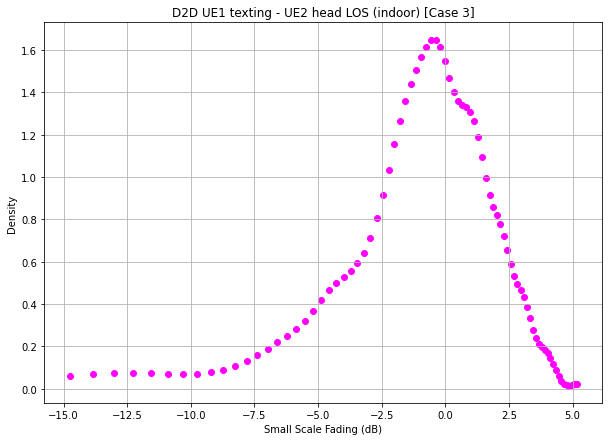

In [37]:
case = 'D2D UE1 texting - UE2 head LOS (indoor) [Case 3]'
estParameters_au_ku_case3 = pd.DataFrame()
estParameters_sku_case3 = pd.DataFrame()
Xdata, Ydata = getDensityEstimationSamples(UE1text_UE2head_LOS.dropna(), nExtractedSamples, case)

In [52]:
# print('='*30+' KAPPA-MU '+'='*30)
# fitnessType = 'MSE'
# printSummary(case, fitnessType)
# ku_kappa_mse, ku_mu_mse, ku_omega_mse = geneticAlgorithm_ku(Xdata, Ydata, 222) 

# fitnessType = 'RAD'
# printSummary(case, fitnessType)
# ku_kappa_rad, ku_mu_rad, ku_omega_rad = geneticAlgorithm_ku(Xdata, Ydata, 192) 

# print('='*30+' ALPHA-MU '+'='*30)
# fitnessType = 'MSE'
# printSummary(case, fitnessType)
# au_kappa_mse, au_mu_mse, au_r_hat_mse = geneticAlgorithm_au(Xdata, Ydata, 220)

# fitnessType = 'RAD'
# printSummary(case, fitnessType)
# au_kappa_rad, au_mu_rad, au_r_hat_rad = geneticAlgorithm_au(Xdata, Ydata, 120)

print('='*30+' SHADOWED KAPPA-MU T1 '+'='*30)
fitnessType = 'MSE'
printSummary(case, fitnessType)
sku_kappa_mse, sku_mu_mse, sku_omega_mse, sku_md_mse = geneticAlgorithm_sku(Xdata, Ydata, 241)

fitnessType = 'RAD'
printSummary(case, fitnessType)
sku_kappa_rad, sku_mu_rad, sku_omega_rad, sku_md_rad = geneticAlgorithm_sku(Xdata, Ydata, 179)

============================== SHADOWED KAPPA-MU T1 ==============================
Genetic Algorithm Fitting
Fitness Type: MSE
Case: D2D UE1 texting - UE2 head LOS (indoor) [Case 3]

Satisfactory Threshold reached!
Elapsed time is 2.772392511367798 seconds.

Best Fitness: 241.3093993238348
Best Gen: 10
Kappa: 11.665003066892028
Mu: 1.5242947038854398
Omega: 1.0608929991880336
Md: 5.616296366019136
Genetic Algorithm Fitting
Fitness Type: RAD
Case: D2D UE1 texting - UE2 head LOS (indoor) [Case 3]

Satisfactory Threshold reached!
Elapsed time is 15.175546646118164 seconds.

Best Fitness: 179.1444293290249
Best Gen: 83
Kappa: 7.736080664931223
Mu: 0.8876764683227555
Omega: 1.0568851752880535
Md: 29.205474455829332


#### Estimated Parameters

In [53]:
nls_ku_case3 = [3.8111, 1.5, 1.0491] # KappaMu NLS
nls_au_case3 = [2.1461, 3.4643, 1.0418] # AlphaMu NLS
nls_sku_case3 = [11, 1.0888, 1.0675, 6.3392]

estParameters_au_ku_case3['MLE - KappaMu'] = nls_ku_case2
estParameters_au_ku_case3['MLE - AlphaMu'] = nls_au_case3
estParameters_au_ku_case3['GA: KappaMu - MSE'] = ku_kappa_mse, ku_mu_mse, ku_omega_mse
estParameters_au_ku_case3['GA: KappaMu - RAD'] = ku_kappa_rad, ku_mu_rad, ku_omega_rad
estParameters_au_ku_case3['GA: AlphaMu - MSE'] = au_kappa_mse, au_mu_mse, au_r_hat_mse
estParameters_au_ku_case3['GA: AlphaMu - RAD'] = au_kappa_rad, au_mu_rad, au_r_hat_rad
estParameters_sku_case3['NLS - Shad. KappaMu T1'] = nls_sku_case3
estParameters_sku_case3['GA: Shad. KappaMu T1 - MSE'] = sku_kappa_mse, sku_mu_mse, sku_omega_mse, sku_md_mse
estParameters_sku_case3['GA: Shad. KappaMu T1 - RAD'] = sku_kappa_rad, sku_mu_rad, sku_omega_rad, sku_md_rad

index = pd.Index(['kappa', 'mu', 'omega/r_hat'])
estParameters_au_ku_case3 = estParameters_au_ku_case3.set_index(index)
display(estParameters_au_ku_case3)

index = pd.Index(['kappa', 'mu', 'omega', 'md'])
estParameters_sku_case3 = estParameters_sku_case3.set_index(index)
display(estParameters_sku_case3)

,MLE - KappaMu,MLE - AlphaMu,GA: KappaMu - MSE,GA: KappaMu - RAD,GA: AlphaMu - MSE,GA: AlphaMu - RAD
kappa,3.05560,2.1461,10.741299,37.142893,2.281576,3.038490
mu,1.50000,3.4643,0.659805,0.193795,3.059199,1.620592
omega/r_hat,0.98751,1.0418,1.047467,1.059485,1.045564,1.062630


,NLS - Shad. KappaMu T1,GA: Shad. KappaMu T1 - MSE,GA: Shad. KappaMu T1 - RAD
kappa,11.0000,11.665003,7.736081
mu,1.0888,1.524295,0.887676
omega,1.0675,1.060893,1.056885
md,6.3392,5.616296,29.205474


#### Plots

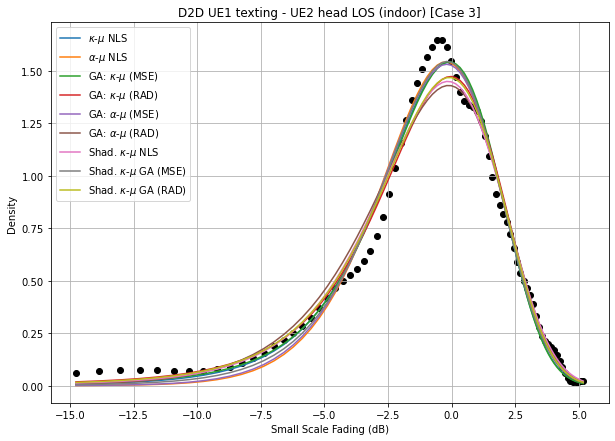

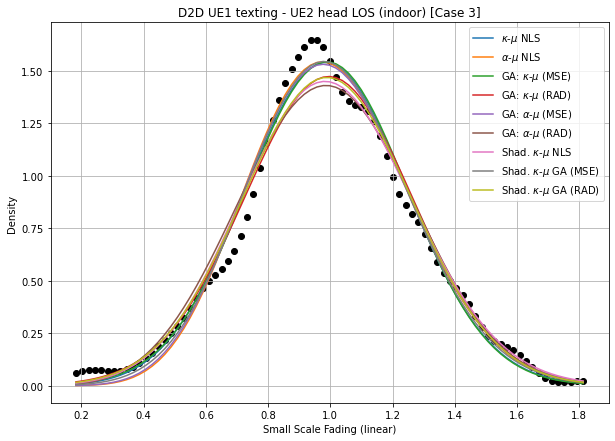

In [54]:
ku_case3_pdf = KappaMuPDF(Xdata, nls_ku_case3[0], nls_ku_case3[1], nls_ku_case3[2]).astype(float)
au_case3_pdf = AlphaMuPDF(Xdata, nls_au_case3[0], nls_au_case3[1], nls_au_case3[2]).astype(float)
sku_case3_pdf = shadowedKappaMuPDF(Xdata, nls_sku_case3[0], nls_sku_case3[1], nls_sku_case3[2], nls_sku_case3[3]).astype(float)

plotResults(Xdata,\
     Ydata,\
     ku_case3_pdf,\
     au_case3_pdf,\
     estParameters_au_ku_case3['GA: KappaMu - MSE'],\
     estParameters_au_ku_case3['GA: KappaMu - RAD'],\
     estParameters_au_ku_case3['GA: AlphaMu - MSE'],\
     estParameters_au_ku_case3['GA: AlphaMu - RAD'],\
     sku_case3_pdf,\
     estParameters_sku_case3['GA: Shad. KappaMu T1 - MSE'],\
     estParameters_sku_case3['GA: Shad. KappaMu T1 - RAD'],\
     case)



#### AIC Values

In [55]:
## AIC Analysis
data = UE1text_UE2head_LOS.dropna()
n = len(data)
K = 3

print('Case: {}'.format(case))

AIC_case1 = computeAIC(data, n, K,\
                        nls_ku_case3,\
                        nls_au_case3,\
                        estParameters_au_ku_case3['GA: KappaMu - MSE'],\
                        estParameters_au_ku_case3['GA: KappaMu - RAD'],\
                        estParameters_au_ku_case3['GA: AlphaMu - MSE'],\
                        estParameters_au_ku_case3['GA: AlphaMu - RAD'],\
                        nls_sku_case3,\
                        estParameters_sku_case3['GA: Shad. KappaMu T1 - MSE'],\
                        estParameters_sku_case3['GA: Shad. KappaMu T1 - RAD'])

Case: D2D UE1 texting - UE2 head LOS (indoor) [Case 3]
4


,Methods,Akaike Information Criteria
0,GA - KappaMu (Fitness = RAD),74.894757
1,GA - KappaMu (Fitness = MSE),76.037205
2,GA - Shad. KappaMu T1 (Fitness = RAD),77.314075
3,NLS - KappaMu,77.525196
4,NLS - Shad. KappaMu T1,78.960833
5,GA - AlphaMu (Fitness = RAD),79.446625
6,GA - Shad. KappaMu T1 (Fitness = MSE),82.602500
7,GA - AlphaMu (Fitness = MSE),90.205011
8,NLS - AlphaMu,93.094742
